In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint, solve_ivp
from scipy.stats import beta
from local_functions import *

# A model for behavior adoption/adaptation on weighted co-evolving networks

## 1. Introduction

In this notebook, we collect ideas for modelling behaviour adoption on weighted, co-evolving networks. The ideas in this notebook are inspired by the social study of alcohol consumption of students in the SHINE MURI project. As part of this study, students participated in a programme of app-based questionnaires (EMA) over several weeks. These questionnaires asked students to report their recent alcohol consumption and reflect on it. Different cohorts of students received different instructions on how to reflect on the behaviour: a mindfulness approach and a 'perspective-taking' approach. Another cohort served as the control group and did not receive special instructions on how to reflect on their behaviour.

## 2. A linear model with coevolution

### 2.1. A simple model for behaviour "diffusion"

We start by considering a diffusion model of the form

$$\dot x(t) =-Lx(t) \tag{1}$$

as a model for behaviour adoption. In this equation, $x(t)=(x_1(t),x_2(t),\dots,x_n(t))^T$ is a column vector of time-dependent node states $x_{i=1,\dots,n}(t)$. For each node (i.e., person) $i$, the real number $x_i$ indicates their likelihood to exhibit a given behavioural trait (or the extent to which they exhibit a given behaviour). The matrix $L:=D-A$ is the combinatorial Laplacian matrix of a weighted network (which, at this point, we assume to be independent of time). One can compute it from the weighted degree matrix $D$ and the weighted adjacency matrix $A$ (which, at this point, we assume to be symmetric).

As long as $A$ is symmetric, the construction of the combinatorial Laplace matrix via $D$ and $A$ ensures that $L$ has a constant row sum of $0$ (i.e., $\forall i: \sum_{j}L_{ij}=0$) and a constant column sum of $0$ (i.e., $\forall j: \sum_{i}L_{ij}=0$). The zero row sum and zero column sum of the Laplace matrix lead to two characteristics of diffusive dynamics:
1. Because of the constant row sum, we have $$L{\bf 1}_n=(\sum_{j}L_{ij})_{i=1,\dots,n}={\bf 0}_n\,,$$ which indicates that $x={\bf 1}_n$ is a fixed point of our dynamics.

2. Because of the constant column sum, we have that the sum of elements of $\dot x(t)$ is $$\sum_i\dot x_i(t) = \sum_i(Lx(t))_i = \sum_{i}\sum_{j}L_{ij}x_j(t) = \sum_{j}\left(\sum_{i}L_{ij}\right)x_j(t) = 0\,,$$ which implies conservation of the mass $\sum_j x_j(t)$ over time.

To demonstrate that the model captures these characteristics of diffusive dynamics, we run a simulation of the model on an undirected line graph with 20 nodes. As our initial value $x(t=0)$, we choose a bimodal distribution over the line graph's nodes.

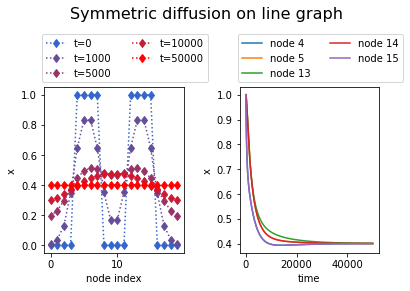

In [12]:
# set time steps
t0, t1, dt = 0, 50.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1

# construct adjacency matrix for a line graph
A = np.eye(20,k=1)+np.eye(20,k=-1) # unweighted adjacency matrix

# run simulation
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt)
plotSim(dat, lines=[[0, 1000, 5000, 10000, 50000], 5], 
    figtitle='Symmetric diffusion on line graph')
plt.savefig('figure1.png', dpi=300)
#videoSim(dat, ncols=2, nrows=nrows, 
#         layout=np.tile(['bars', 'graph'], nrows), 
#         frame=np.repeat(np.round(np.linspace(0, (t1-t0)/dt-1, nrows)),2))

We see that this system approaches a homogeneous steady state (i.e., $x_i(t)=x_j(t)$ for all pairs $(i,j)$ as $t\rightarrow\infty$) at which each node $i$ has a value $x_i$ that is equal to the mean of the elements of the initial value $x(t=0)$.

Thus far, we have discussed that the model $\dot x(t) =-Lx(t)$ with a static, symmetric $L$ reproduces two characteristics of diffusion dynamics: 
1. existence of a homogeneous steady state (because of $L$'s zero row sum)
2. conservation of mass (because of $L$'s zero column sum)

Going forward, we would like to consider asymmetric Laplace and adjacency matrices to study dynamics on directed and/or asymmetrically weighted graphs. In such a graph a node's in-degree and out-degree can be different from one another, so the matrix $D_in$ of in-degrees and the matrix $D_{out}$ of out-degrees are not the same. We see that replacing $D$ in Equation (1) by $D_{in}$ leads to a matrix $L$ with a constant row sum of 0 and a possibly not-constant and/or non-zero column sum. Conversely, replacing $D$ by $D_{out}$ leads to a matrix $L$ with constant column sum and a possibly not-constant and/or non-zero column sum. This means that, for directed non-regular networks, the model in Equation (1) can either have a guaranteed homogenous steady state or a guaranteed conservation of mass. 

To demonstrate the changes that occur when replacing $D$ by $D_{in}$ or $D_{out}$, we simulate the two respective models on a directed random graph.

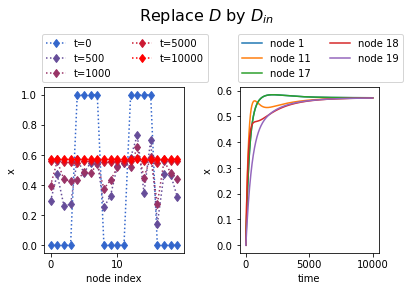

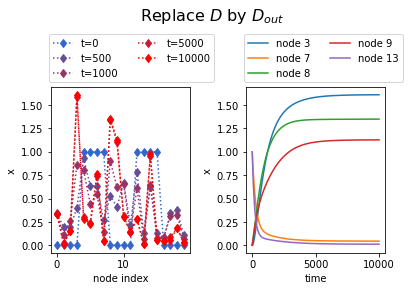

In [13]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in')
plotSim(dat, lines=[[0, 500, 1000, 5000, 10000], 5],
    figtitle='Replace $D$ by $D_{in}$')
plt.savefig('figure_Din.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='out')
plotSim(dat, lines=[[0, 500, 1000, 5000, 10000], 5],
    figtitle='Replace $D$ by $D_{out}$')

plt.savefig('figure_Dout.png', dpi=300)

For modeling behavioral changes induced through social ties, it seems reasonable to construct a model with a homogeneous steady state. (By contrast, conservation of mass does not seem like a feature that our model necessarily needs to include.) Hence, we will define the combinatorial Laplace matrix for directed networks as $L:=D_{in}-A$.

### 2.2. Adding coevolution

Let us now consider a coevolving network (i.e., a network that changes in dependence of the nodal dynamics with time). The motivation for this change is the hypothesis that student's in the SHINE study may adjust their social behavior according to their (intended) alcohol consumption. Students who are light drinkers (or intend to be light drinkers) may reduce the time that they spend with peers who are heavy drinkers.

To model this hypothesized homophily, we use a time-dependent Laplacian matrix $L(t)=D_{in}(t)-A(t)$. Let us first consider that the elements of $L(t)$ change according to 

$$\dot A_{ij}(t) = - \alpha A_{ij}(t) (x_i(t)-x_j(t))^2 =: - \alpha A_{ij}(t) \Delta_{ij}(t)\,,\tag{2}$$ 

where $\Delta(t)$ is a time-dependent squared-distance matrix with elements $\Delta_{ij}(t)=|x_i(t)-x_j(t)|^2$. The scaling parameter $\alpha$ indicates the strength of the homophily effect, i.e., how strongly students change their social network to increase the time that they spent with like-minded peers. 

One can express the coevolution equation (2) in terms of elements of the Laplace matrix, 
$$\dot L_{ij}(t) = - \alpha L_{ij}(t) \Delta_{ij}(t)\,-\delta_{ii}\sum_{j}L_{ij}(t) \Delta_{ij}(t).$$
The equation is longer than (2), but easier to implement computationally.

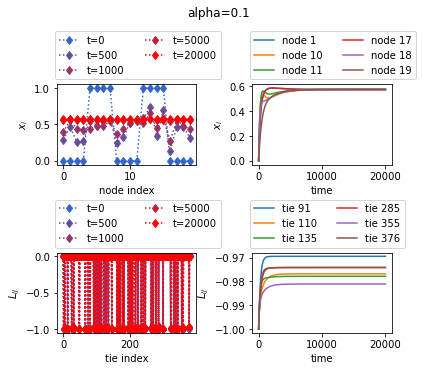

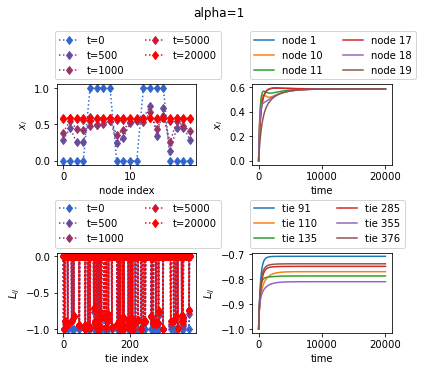

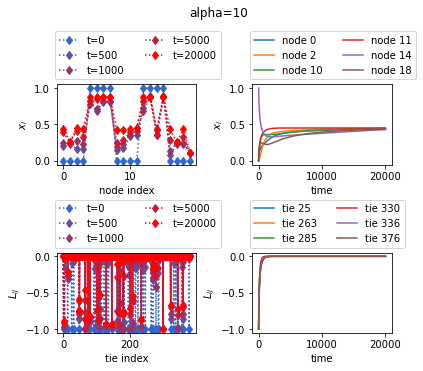

In [14]:
# set time steps
t0, t1, dt = 0, 20.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', 
               coevolving=True, fix_indegree=False, alpha=0.1)
plotSim(dat, lines=[[0, 500, 1000, 5000, 20000], 6], coevolving=True)
plt.suptitle('alpha=0.1', y=.88)
plt.savefig('variable_indegree_alpha0.1.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', 
               coevolving=True, fix_indegree=False, alpha=1)
plotSim(dat, lines=[[0, 500, 1000, 5000, 20000], 6], coevolving=True)
plt.suptitle('alpha=1', y=.88)
plt.savefig('variable_indegree_alpha1.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', 
               coevolving=True, fix_indegree=False, alpha=10)
plotSim(dat, lines=[[0, 500, 1000, 5000, 20000], 6], coevolving=True)
plt.suptitle('alpha=10', y=.88)
plt.savefig('variable_indegree_alpha10.png', dpi=300)

Is there a third regime?

A problem with Equation (2) is that is has an attracting fixed point at $L(t)=0$. Indeed, we observe that many elements $L_{ij}$ that are zero at $t=0$ approach a value of $0$ very quickly. This leads to a de facto disconnected graph in which each connected component has its own homogeneous steady-state. This makes sense because, in its current form, it only includes an effect that weakens a person's ties to dissimilar friends but no effect that strengthens a person's ties to its similar friends. To change this, we include a constraint that fixes the in-degree of nodes.

$$\alpha^{-1}\dot A_{ij}(t) = - A_{ij}(t) \Delta_{ij}(t) + \frac{(1-\delta_{ij})}{n-1}\sum_\ell A_{i\ell}(t) \Delta_{i\ell}(t)$$

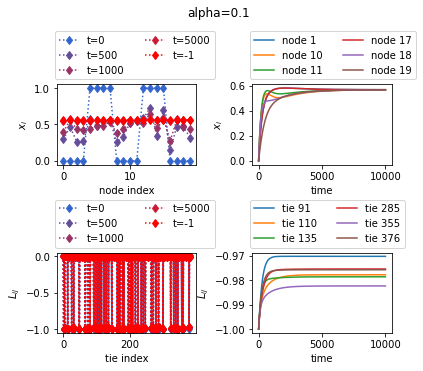

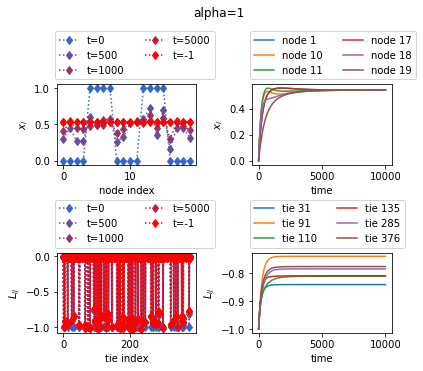

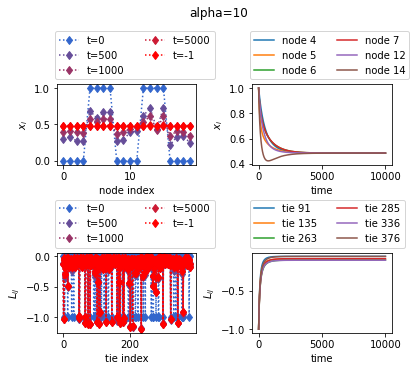

In [15]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', coevolving=True, fix_indegree=True, alpha=0.1)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], coevolving=True)
plt.suptitle('alpha=0.1', y=.88)
plt.savefig('fix_indegree_alpha0.1.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', coevolving=True, fix_indegree=True, alpha=1)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], coevolving=True)
plt.suptitle('alpha=1', y=.88)
plt.savefig('fix_indegree_alpha1.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', coevolving=True, fix_indegree=True, alpha=10)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], coevolving=True)
plt.suptitle('alpha=10', y=.88)
plt.savefig('fix_indegree_alpha10.png', dpi=300)

Initial observations:
1. For small $\alpha$ (i.e., $\alpha\approx1$), the system behaves like the static case and approaches a homogenous steady state.
2. For large $\alpha$ (i.e., $\alpha\approx10$), most tie strengths approach zero and a few ties becomes very strong. This seems like the weighted-network equivalent of fragmentation.

Some questions:
1. What are the system's fixed points? Does it converge to stable fixed points?
2. How long does it take the system to converge?
3. Why is $\alpha\approx1$ small? 
4. How and when does the phase transition from small to large alpha occur?
5. How does this transition depend on other system/ network parameters?
6. How does the distribution of elements of $A(t)$ evolve over time?

### 2.3. Adding intention

Some interventions do not influence a person's behavior directly. Instead, they influence a person's intention to change their behavior. To understand the effect of interventions on behavior, we want to include such intentions to change in our model. So far, our model lets us characterize the state of a node $i$ by a (scalar) variable $x_i$ that reflects how strongly node $i$ displays this behavior. We now add a second state variable $y_i$ that represents the strength of a person's intention to **reduce** their behavior display $x$. Taken together, we now have a system of two vector-valued and one matrix-valued differential equation:

$$\dot x(t) = -L(t)x(t) - \gamma y(t) x(t)\\
\tau^{-1}\dot y(t) = -L(t)y(t) - \rho_Y y(t)\tag{3}\\
\alpha^{-1}\dot A_{ij}(t) = -A_{ij}(t) \Delta_{ij}(t) + \frac{(1-\delta_{ij})}{n-1}\sum_\ell A_{i\ell}(t) \Delta_{i\ell}(t)\,.$$

In this set of equations, the parameters $\alpha$ and $\theta$ determine how fast the $L(t)$ and $y(t)$ change in comparison to $x(t)$. The parameter $\beta$ determines how strongly intention affects behavior. The parameter $\gamma$ determines how quickly an intention fades in the absence of external stimuli.

We can non-dimensionalize the system such that
$$\dot x(t) = -L(t)x(t) - y(t) x(t)\\
\dot y(t) = -\beta L(t)y(t) - y(t)\tag{3}\\
\dot A_{ij}(t) = -\alpha A_{ij}(t) \Delta_{ij}(t) + \frac{(1-\delta_{ij})}{n-1}\sum_\ell A_{i\ell}(t) \Delta_{i\ell}(t)\,.$$

Note that when $y_0 = 0$, the intention vector remains zero for all time, and the zero intention does not affect $x(t)$ or $L(t)$.

Negative intentions/ drinking variables <- need to interpret y as external forcing

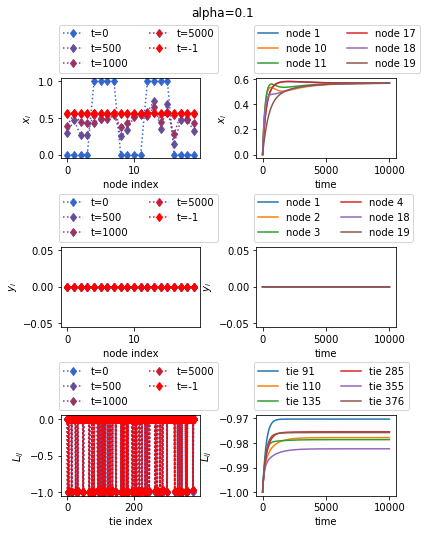

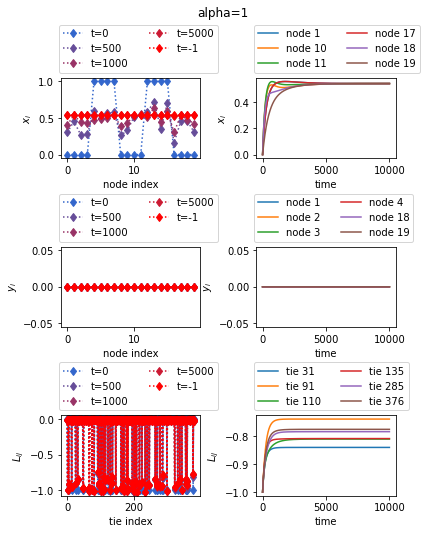

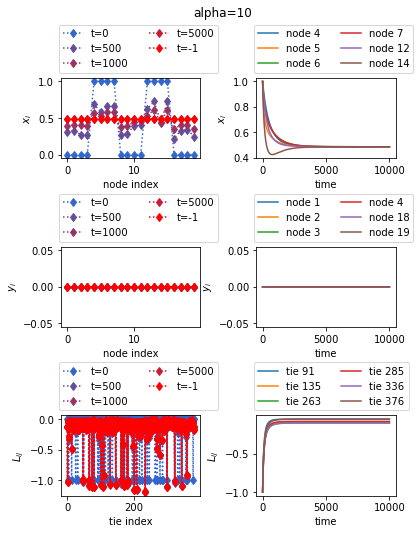

In [16]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', intention=True,
               coevolving=True, fix_indegree=True, alpha=0.1)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle('alpha=0.1', y=.88)
plt.savefig('alpha0.1.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', intention=True,
               coevolving=True, fix_indegree=True, alpha=1)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle('alpha=1', y=.88)
plt.savefig('alpha1.png', dpi=300)

dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', intention=True,
               coevolving=True, fix_indegree=True, alpha=10)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle('alpha=10', y=.88)
plt.savefig('alpha10.png', dpi=300)

Choosing a different starting value for $y$ ...

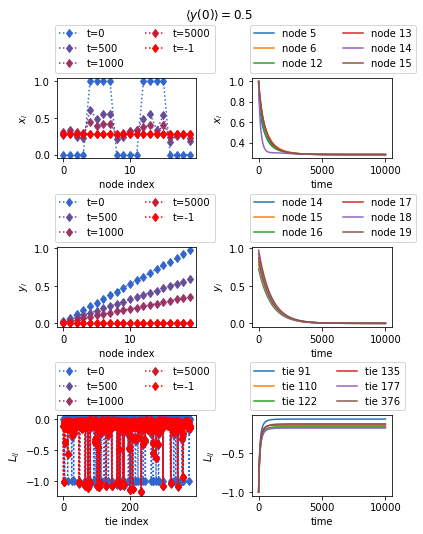

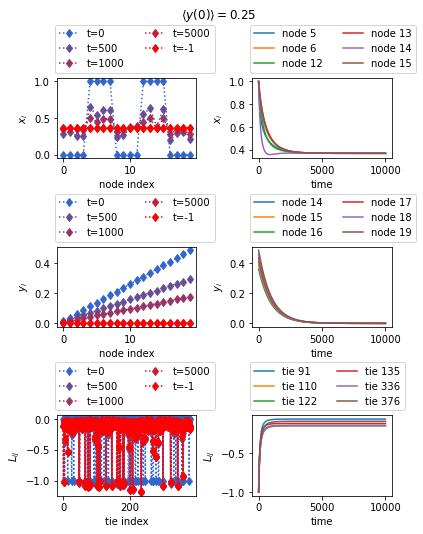

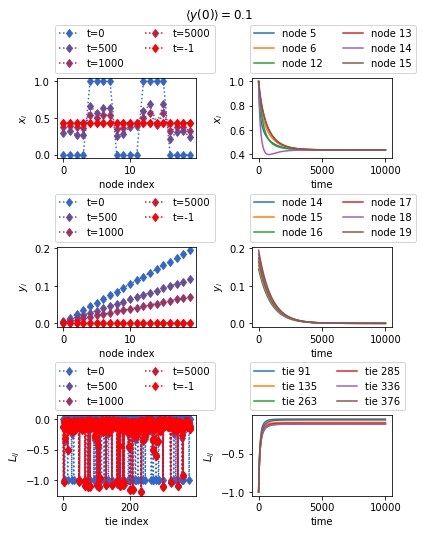

In [17]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1
y0 = (np.arange(20)+0.5)/20

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, y0=y0, t0=t0, t1=t1, dt=dt, degree='in', intention=True,
               coevolving=True, fix_indegree=True, alpha=10)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'$\langle y(0)\rangle=0.5$', y=.88)
plt.savefig('alpha0.1.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0/2, t0=t0, t1=t1, dt=dt, degree='in', intention=True,
               coevolving=True, fix_indegree=True, alpha=10)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'$\langle y(0)\rangle=0.25$', y=.88)
plt.savefig('alpha1.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0/5, t0=t0, t1=t1, dt=dt, degree='in', intention=True,
               coevolving=True, fix_indegree=True, alpha=10)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'$\langle y(0)\rangle=0.1$', y=.88)
plt.savefig('alpha10.png', dpi=300)

Negative intention? vs mean field? barbel community structure

We observe that $x(t\rightarrow\infty)$ varies with the mean value of the initial intention $y(t=0)$. Changing the elements of $y(t=0)$ while keeping their mean the same can change $x(t\rightarrow\infty)$. We need a different visualization to show these observations concisely.

<font color=' #fad7a0 '>
<h3>2.4 Adding reversion to mean or inherent behavior</h3>
    
We may assume that every person has a "natural" behavioral state or that a group of people have an interval of natural behavioral states that they revert to without social or other stimuli that would encourage behavior change. For now, we only consider a very simple model of such a reversion to a natural state. We assume that all node's have an identical scalar natural states $\overline{x}$. Including reversion to $\overline{x}$ in our model leads to
$$\dot x(t) = -L(t)x(t) - \gamma y(t) -\rho_X (x-\overline{x})\\
\tau^{-1}\dot y(t) = -L(t)y(t) - \rho_Y y(t)\tag{4}\\
\alpha^{-1}\dot A_{ij}(t) = -A_{ij}(t) \Delta_{ij}(t) + \frac{(1-\delta_{ij})}{n-1}\sum_\ell A_{i\ell}(t) \Delta_{i\ell}(t)\,.$$
It is not clear that the assumption that individuals have natural behavioral states is at all accurate. Even if such states exist, it is almost surely inaccurate to assume that these states would be the same for all individuals. However, understanding the dynamics of the model above might shed some light on what to expect when we replace $\overline{x}$ by a vector of individual natural states. Additionally, it might also help with reigning in some of the exponential growth that we observe for some behavior states in simulations of previous versions of this model.</font> 

Is this necessary when one interprets $x$ as drinking propensity rather than actual number of drinks?

## 3. Modelling interventions

### 3.1. General setup

### 3.2. Direct interventions

$$\dot x(t) = -[L(t) + y(t) + \iota_X]\,x(t)\\
\dot y(t) = -[\beta L(t) + 1]\, y(t) + \iota_Y\tag{5}\\
\dot A_{ij}(t) = -\alpha A_{ij}(t) \Delta_{ij}(t) + \frac{(1-\delta_{ij})}{n-1}\sum_\ell A_{i\ell}(t) \Delta_{i\ell}(t)\,.$$

$$\iota_Y = const.$$

$$\iota_{Y,i} = x_i-min_{j\in N_i}(x_j)$$

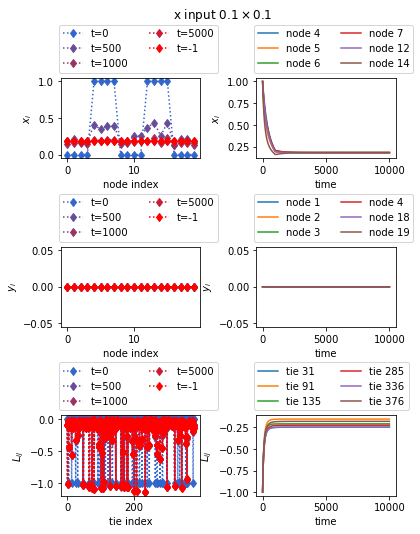

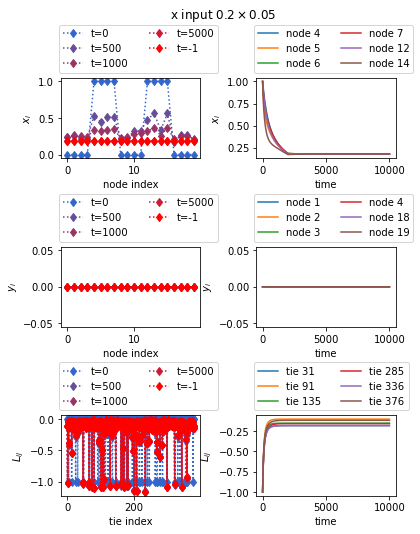

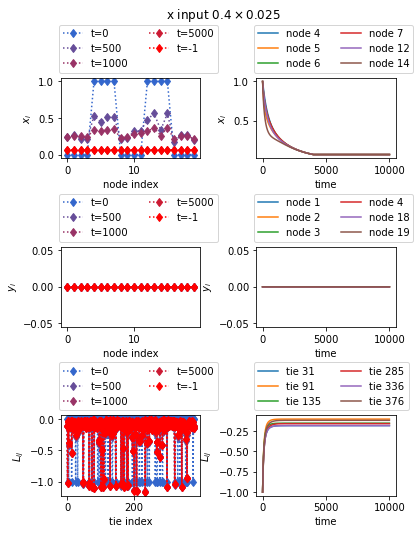

In [18]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1
y0 = np.zeros(20)

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, y0=y0, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    x_input=inputFunction('rect', t0=0, t1=1, max_val=1))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'x input $0.1\times0.1$', y=.88)
plt.savefig('input-x0.1.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0/2, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    x_input=inputFunction('rect', t0=0, t1=2, max_val=0.5))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'x input $0.2\times 0.05$', y=.88)
plt.savefig('input-x0.2.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0/5, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    x_input=inputFunction('rect', t0=0, t1=4, max_val=0.5))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'x input $0.4\times 0.025$', y=.88)
plt.savefig('input-x0.4.png', dpi=300)

### 3.3. Modelling a mindfulness approach

$$\dot x(t) = -L(t)x(t) - \gamma y(t) x(t)\\
\tau^{-1}\dot y(t) = -L(t)y(t) - \rho_Y y(t) + \iota_Y(t) \tag{6}\\
\alpha^{-1}\dot A_{ij}(t) = -A_{ij}(t) \Delta_{ij}(t) + \frac{(1-\delta_{ij})}{n-1}\sum_\ell A_{i\ell}(t) \Delta_{i\ell}(t)\,.$$

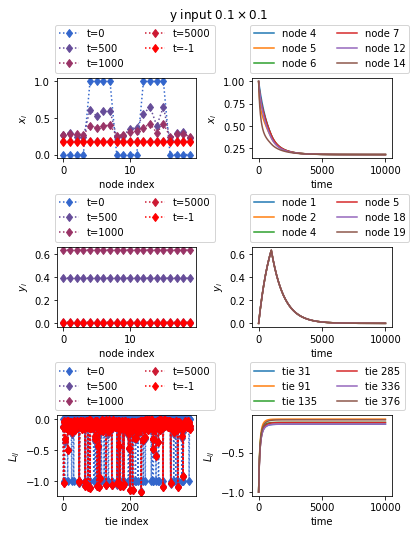

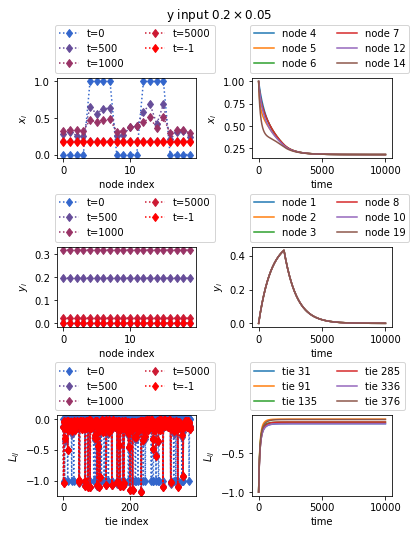

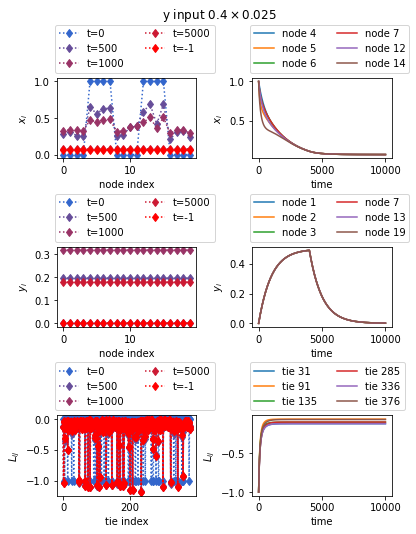

In [19]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1
y0 = np.zeros(20)

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, y0=y0, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    y_input=inputFunction('rect', t0=0, t1=1, max_val=1))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'y input $0.1\times0.1$', y=.88)
plt.savefig('inpuy-y0.1.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0/2, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    y_input=inputFunction('rect', t0=0, t1=2, max_val=0.5))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'y input $0.2\times 0.05$', y=.88)
plt.savefig('input-y0.2.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0/5, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    y_input=inputFunction('rect', t0=0, t1=4, max_val=0.5))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'y input $0.4\times 0.025$', y=.88)
plt.savefig('input-y0.4.png', dpi=300)

### 3.4. Modelling a perspective-taking approach

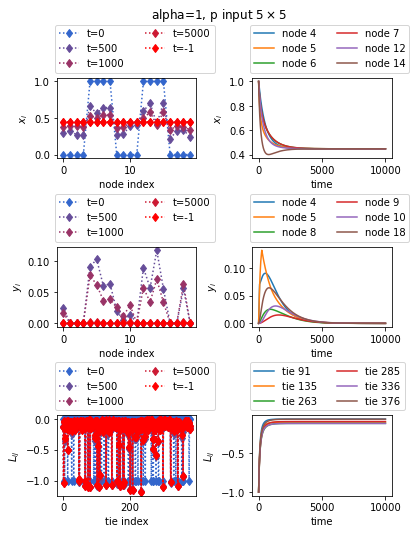

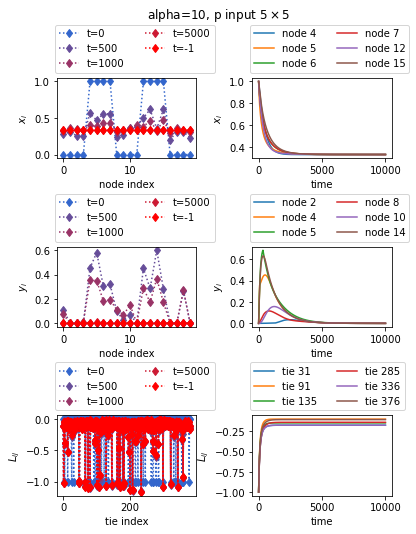

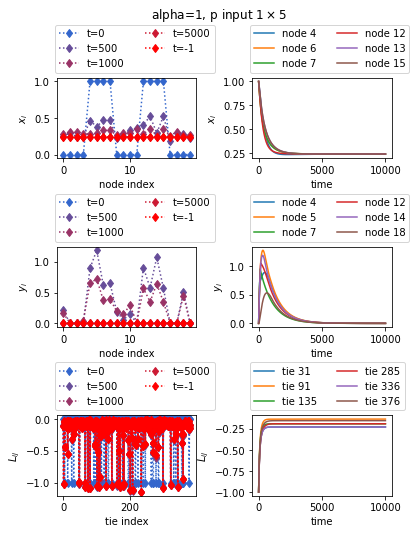

In [20]:
# set time steps
t0, t1, dt = 0, 10.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1
y0 = np.zeros(20)

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, y0=y0, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    perspective_taking=inputFunction('rect', t0=0, t1=5, max_val=1))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'alpha=1, p input $5\times5$', y=.88)
plt.savefig('input-p5_alpha1.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    perspective_taking=inputFunction('rect', t0=0, t1=5, max_val=5))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'alpha=10, p input $5\times5$', y=.88)
plt.savefig('input-p5_alpha10.png', dpi=300)

dat = simulate(A=A, x0=x0, y0=y0, t0=t0, t1=t1, dt=dt, degree='in', 
    intention=True, coevolving=True, fix_indegree=True, alpha=10,
    perspective_taking=inputFunction('rect', t0=0, t1=1, max_val=10))
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], intention=True, coevolving=True)
plt.suptitle(r'alpha=1, p input $1\times5$', y=.88)
plt.savefig('input-p1_alpha1.png', dpi=300)

### 3.5. Heterogenous Interventions

#### 3.5.1 Intervenening on nodes with largest $x$

#### 3.5.2 Intervening on nodes with highest degree

#### 3.5.3. Intervening on nodes with highest betweennees

## 4. Individual heterogeneity